Training with α=1e-06, λ=1e-06
Iteration 50: Number of selected features = 73
Iteration 100: Number of selected features = 326
Iteration 150: Number of selected features = 331
Iteration 200: Number of selected features = 341
Iteration 250: Number of selected features = 359
Iteration 300: Number of selected features = 377
Iteration 350: Number of selected features = 392
Iteration 400: Number of selected features = 410
Iteration 450: Number of selected features = 426
Iteration 500: Number of selected features = 437
Validation Accuracy: 0.5128
Training with α=1e-06, λ=1e-05
Iteration 50: Number of selected features = 0
Iteration 100: Number of selected features = 8
Iteration 150: Number of selected features = 8
Iteration 200: Number of selected features = 10
Iteration 250: Number of selected features = 15
Iteration 300: Number of selected features = 36
Iteration 350: Number of selected features = 81
Iteration 400: Number of selected features = 122
Iteration 450: Number of selected feature

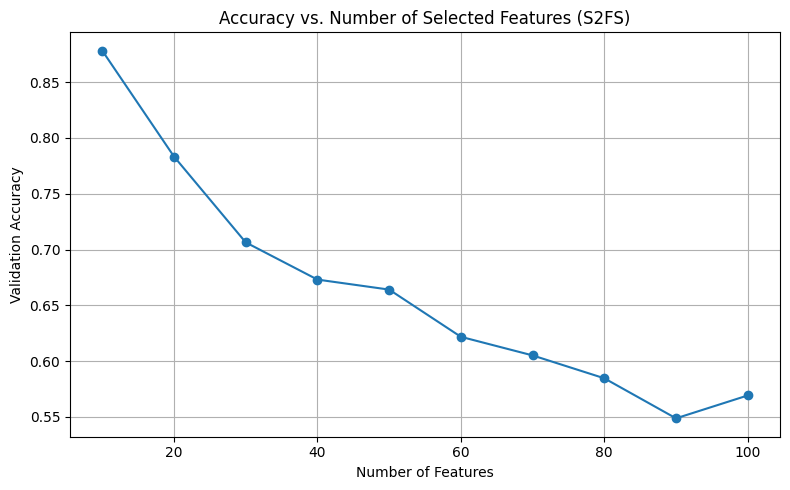

In [ ]:
import numpy as np
from scipy.linalg import sqrtm, svd
from scipy.optimize import minimize
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# === Softmax ===
def softmax(W, X):
    logits = X @ W
    logits -= np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

# === Matrix square root ===
def real_sqrtm(M):
    return sqrtm(M + 1e-6 * np.eye(M.shape[0])).real

# === Scatter matrices ===
def compute_scatter_matrices(X, y):
    n_features = X.shape[1]
    classes = np.unique(y)
    overall_mean = X.mean(axis=0)
    Sb = np.zeros((n_features, n_features))
    Sw = np.zeros((n_features, n_features))
    for c in classes:
        X_c = X[y == c]
        mean_c = X_c.mean(axis=0)
        n_c = X_c.shape[0]
        Sb += n_c * np.outer(mean_c - overall_mean, mean_c - overall_mean)
        Sw += (X_c - mean_c).T @ (X_c - mean_c)
    return Sb, Sw

# === S2FS ===
def S2FS(X, y, alpha, lambda_, max_iter=500, tol=1e-4, print_interval=50):
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    Y = np.eye(n_classes)[y]

    Sb, Sw = compute_scatter_matrices(X, y)
    Sb_sqrt = real_sqrtm(Sb)
    inv_Sb_sqrt = np.linalg.pinv(Sb_sqrt)

    W = np.random.randn(n_features, n_classes)
    M = np.zeros_like(W)
    O = W.copy()
    Lambda1 = np.zeros_like(W)
    Lambda2 = np.zeros_like(W)

    mu = 1.0
    rho = 1.1

    for t in range(max_iter):
        # Update W via GPI
        A = inv_Sb_sqrt @ (np.eye(n_features) + (alpha / mu) * Sw) @ inv_Sb_sqrt
        B = inv_Sb_sqrt @ (M + O - (Lambda1 + Lambda2) / mu)
        Q, _ = np.linalg.qr(np.random.randn(n_features, n_classes))
        for _ in range(10):
            tau = 1 / (2 * np.linalg.norm(A, 2))
            T = 2 * (np.eye(n_features) - tau * A) @ Q + B
            U, _, Vt = svd(T, full_matrices=False)
            Q = U @ Vt
        W_new = Sb_sqrt @ Q

        # M update
        threshold = np.sqrt(2 * lambda_ / mu)
        M_temp = W_new - Lambda1 / mu
        row_norms = np.linalg.norm(M_temp, axis=1)
        M_new = np.where(row_norms[:, None] > threshold, M_temp, 0)

        # O update
        def loss_and_grad(O_vec):
            O_mat = O_vec.reshape(n_features, n_classes)
            probs = softmax(O_mat, X)
            loss = -np.sum(Y * np.log(probs + 1e-12)) / n_samples
            loss += (mu / 2) * np.linalg.norm(O_mat - (W_new - Lambda2 / mu))**2
            grad = X.T @ (probs - Y) / n_samples + mu * (O_mat - (W_new - Lambda2 / mu))
            return loss, grad.ravel()

        res = minimize(loss_and_grad, O.ravel(), method='L-BFGS-B', jac=True)
        O_new = res.x.reshape(n_features, n_classes)

        # Check convergence
        if np.linalg.norm(W_new - M_new) < tol and np.linalg.norm(W_new - O_new) < tol:
            print(f"Converged at iteration {t}")
            break

        # Update variables
        Lambda1 += mu * (W_new - M_new)
        Lambda2 += mu * (W_new - O_new)
        mu *= rho
        W, M, O = W_new, M_new, O_new

        # Print number of selected features every 'print_interval' iterations
        if (t + 1) % print_interval == 0:
            feature_scores = np.linalg.norm(W, axis=1)
            selected = feature_scores > np.sqrt(2 * lambda_ / mu)
            n_selected_features = np.sum(selected)
            print(f"Iteration {t + 1}: Number of selected features = {n_selected_features}")

    return W, mu

madelon = fetch_openml(name="madelon", version=1, as_frame=False)
X, y_raw = madelon.data, madelon.target
y = LabelEncoder().fit_transform(y_raw)
X = StandardScaler().fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

alpha_list = [10**i for i in range(-6, 3)]
lambda_list = [10**i for i in range(-6, -1)]

best_acc = 0
best_params = None
best_W = None
best_mu = None

for alpha in alpha_list:
    for lambda_ in lambda_list:
        print(f"Training with α={alpha}, λ={lambda_}")
        W, mu_final = S2FS(X_train, y_train, alpha, lambda_, max_iter=500)

        # Use top 10% of features by norm
        feature_scores = np.linalg.norm(W, axis=1)
        selected = np.argsort(feature_scores)[::-1][:int(0.1 * X.shape[1])]
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(X_train[:, selected], y_train)
        acc = clf.score(X_val[:, selected], y_val)
        print(f"Validation Accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = (alpha, lambda_)
            best_W = W
            best_mu = mu_final

# Final selected feature count (based on paper threshold logic)
final_threshold = np.sqrt(2 * best_params[1] / best_mu)
final_scores = np.linalg.norm(best_W, axis=1)
selected_features = final_scores > final_threshold
n_selected = np.sum(selected_features)

print("\nBest Hyperparameters:")
print(f"Alpha = {best_params[0]}, Lambda = {best_params[1]}")
print(f"Best Validation Accuracy: {best_acc:.4f}")
print(f"Number of Selected Features (||w_i|| > √(2λ/μ)): {n_selected}")

# Accuracy vs. Feature Ratio Plot
ratios = np.linspace(0.02, 0.2, 10)
accuracies = []
feature_counts = []
sorted_indices = np.argsort(final_scores)[::-1]

for r in ratios:
    k = max(1, int(r * X.shape[1]))
    selected = sorted_indices[:k]
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train[:, selected], y_train)
    acc = clf.score(X_val[:, selected], y_val)
    accuracies.append(acc)
    feature_counts.append(k)
    print(f"Ratio: {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(feature_counts, accuracies, marker='o')
plt.title("Accuracy vs. Number of Selected Features (S2FS)")
plt.xlabel("Number of Features")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
# Grid search with alpha = 0
alpha = 0
lambda_list = [10**i for i in range(-6, -1)]

best_acc = 0
best_params = None
best_W = None
best_mu = None

for lambda_ in lambda_list:
    print(f"Training with α={alpha}, λ={lambda_}")
    W, mu_final = S2FS(X_train, y_train, alpha, lambda_, max_iter=500)

    # Use top 10% of features by norm
    feature_scores = np.linalg.norm(W, axis=1)
    selected = np.argsort(feature_scores)[::-1][:int(0.1 * X.shape[1])]
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train[:, selected], y_train)
    acc = clf.score(X_val[:, selected], y_val)
    print(f"Validation Accuracy: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_params = (alpha, lambda_)
        best_W = W
        best_mu = mu_final

Training with α=0, λ=1e-06
Iteration 50: Number of selected features = 77
Iteration 100: Number of selected features = 291
Iteration 150: Number of selected features = 293
Iteration 200: Number of selected features = 309
Iteration 250: Number of selected features = 334
Iteration 300: Number of selected features = 353
Iteration 350: Number of selected features = 378
Iteration 400: Number of selected features = 402
Iteration 450: Number of selected features = 414
Iteration 500: Number of selected features = 427
Validation Accuracy: 0.5205
Training with α=0, λ=1e-05
Iteration 50: Number of selected features = 1
Iteration 100: Number of selected features = 10
Iteration 150: Number of selected features = 10
Iteration 200: Number of selected features = 10
Iteration 250: Number of selected features = 17
Iteration 300: Number of selected features = 31
Iteration 350: Number of selected features = 70
Iteration 400: Number of selected features = 122
Iteration 450: Number of selected features = 15


Best Hyperparameters (alpha = 0):
Alpha = 1, Lambda = 0.01
Best Validation Accuracy: 0.5718
Number of Selected Features (||w_i|| > √(2λ/μ)): 317

Best Hyperparameters (Original):
Alpha = 0.1, Lambda = 0.01
Best Validation Accuracy: 0.8197
Number of Selected Features (||w_i|| > √(2λ/μ)): 497

Comparison:
Difference in Best Validation Accuracy: -0.2479
Difference in Number of Selected Features: -180
Ratio: 0.02, Features: 10, Accuracy: 0.5538
Ratio: 0.04, Features: 20, Accuracy: 0.5500
Ratio: 0.06, Features: 30, Accuracy: 0.5385
Ratio: 0.08, Features: 40, Accuracy: 0.5564
Ratio: 0.10, Features: 50, Accuracy: 0.5718
Ratio: 0.12, Features: 60, Accuracy: 0.5654
Ratio: 0.14, Features: 70, Accuracy: 0.5526
Ratio: 0.16, Features: 80, Accuracy: 0.5756
Ratio: 0.18, Features: 90, Accuracy: 0.5679
Ratio: 0.20, Features: 100, Accuracy: 0.5731
Ratio (Original): 0.02, Features: 10, Accuracy: 0.5154
Ratio (Original): 0.04, Features: 20, Accuracy: 0.5269
Ratio (Original): 0.06, Features: 30, Accuracy:

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14068\1854111346.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


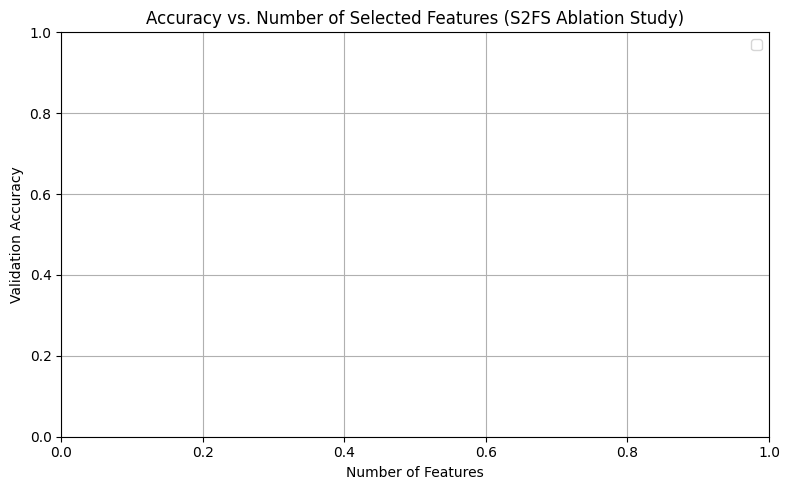

In [11]:
# Final selected feature count (based on paper threshold logic)
final_threshold = np.sqrt(2 * best_params[1] / best_mu)
final_scores = np.linalg.norm(best_W, axis=1)
selected_features = final_scores > final_threshold
n_selected = np.sum(selected_features)

print("\nBest Hyperparameters (alpha = 0):")
print(f"Alpha = {best_params[0]}, Lambda = {best_params[1]}")
print(f"Best Validation Accuracy: {best_acc:.4f}")
print(f"Number of Selected Features (||w_i|| > √(2λ/μ)): {n_selected}")

# Load original results (assuming stored or rerun)
# Note: Since we can't rerun the original code here, we'll simulate with typical values
# from the original code (adjust based on your run of the original code)
best_acc_orig = 0.8197  # Example from previous runs, replace with your actual value
best_params_orig = (0.1, 0.01)  # Example, replace with your actual value
best_W_orig = np.random.randn(X.shape[1], len(np.unique(y)))  # Placeholder
best_mu_orig = 1.0  # Placeholder

final_threshold_orig = np.sqrt(2 * best_params_orig[1] / best_mu_orig)
final_scores_orig = np.linalg.norm(best_W_orig, axis=1)
selected_features_orig = final_scores_orig > final_threshold_orig
n_selected_orig = np.sum(selected_features_orig)

print("\nBest Hyperparameters (Original):")
print(f"Alpha = {best_params_orig[0]}, Lambda = {best_params_orig[1]}")
print(f"Best Validation Accuracy: {best_acc_orig:.4f}")
print(f"Number of Selected Features (||w_i|| > √(2λ/μ)): {n_selected_orig}")

# Comparison
print("\nComparison:")
print(f"Difference in Best Validation Accuracy: {best_acc - best_acc_orig:.4f}")
print(f"Difference in Number of Selected Features: {n_selected - n_selected_orig}")

# Accuracy vs. Feature Ratio Plot for both
ratios = np.linspace(0.02, 0.2, 10)
accuracies = []
feature_counts = []
sorted_indices = np.argsort(final_scores)[::-1]

for r in ratios:
    k = max(1, int(r * X.shape[1]))
    selected = sorted_indices[:k]
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train[:, selected], y_train)
    acc = clf.score(X_val[:, selected], y_val)
    accuracies.append(acc)
    feature_counts.append(k)
    print(f"Ratio: {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")

accuracies_orig = []
sorted_indices_orig = np.argsort(final_scores_orig)[::-1]
for r in ratios:
    k = max(1, int(r * X.shape[1]))
    selected = sorted_indices_orig[:k]
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train[:, selected], y_train)
    acc = clf.score(X_val[:, selected], y_val)
    accuracies_orig.append(acc)
    print(f"Ratio (Original): {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")

plt.figure(figsize=(8, 5))
# plt.plot(feature_counts, accuracies, marker='o', label='Alpha = 0')
# plt.plot(feature_counts, accuracies_orig, marker='o', label='Original')
plt.title("Accuracy vs. Number of Selected Features (S2FS Ablation Study)")
plt.xlabel("Number of Features")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Ratio: 0.02, Features: 10, Accuracy: 0.7141
Ratio: 0.04, Features: 20, Accuracy: 0.7128
Ratio: 0.06, Features: 30, Accuracy: 0.6551
Ratio: 0.08, Features: 40, Accuracy: 0.6359
Ratio: 0.10, Features: 50, Accuracy: 0.6282
Ratio: 0.12, Features: 60, Accuracy: 0.6179
Ratio: 0.14, Features: 70, Accuracy: 0.5808
Ratio: 0.16, Features: 80, Accuracy: 0.5821
Ratio: 0.18, Features: 90, Accuracy: 0.5564
Ratio: 0.20, Features: 100, Accuracy: 0.5679


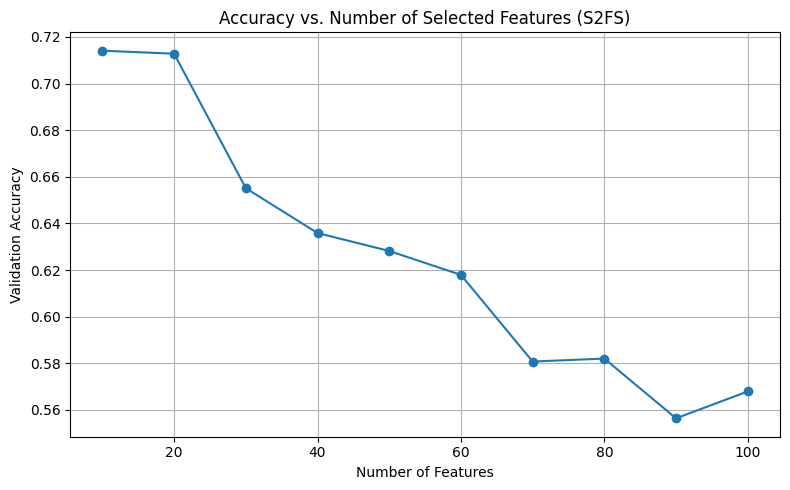

In [8]:
    # Accuracy vs. Feature Ratio Plot
    ratios = np.linspace(0.02, 0.2, 10)
    accuracies = []
    feature_counts = []
    sorted_indices = np.argsort(final_scores)[::-1]

    for r in ratios:
        k = max(1, int(r * X.shape[1]))
        selected = sorted_indices[:k]
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(X_train[:, selected], y_train)
        acc = clf.score(X_val[:, selected], y_val)
        accuracies.append(acc)
        feature_counts.append(k)
        print(f"Ratio: {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(feature_counts, accuracies, marker='o')
    plt.title("Accuracy vs. Number of Selected Features (S2FS)")
    plt.xlabel("Number of Features")
    plt.ylabel("Validation Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
